In [1]:
import numpy as np 
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error as MSE

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import roc_curve, auc, roc_auc_score,confusion_matrix,classification_report,precision_recall_curve

from sklearn.neighbors import KNeighborsClassifier as KNN

from skopt import BayesSearchCV

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Overview

The goal of this project is to utilize a stroke dataset provided by a healthcare organization to identify individuals at a high risk of stroke based on the available features. The primary focus lies in using tree-based classifiers, including decision trees, random forest classifiers, voting classifiers, and gradient boosting. Through this analysis, the aim is not only to evaluate the performance of these algorithms but also to construct a reliable predictor for identifying stroke risk factors in individuals.

In [2]:
stroke = pd.read_csv('/kaggle/input/strokedata/stroke data (1).csv')

In [3]:
#NA Values in smoke_status column
stroke['smoking_status'].fillna('Unknown', inplace = True)

#NA values in Metric 2 column
stroke.columns[stroke.isna().any()]
stroke['metric_2'].fillna(stroke['metric_2'].mean(), inplace=True)

#Checking Null Values
stroke.columns[stroke.isnull().any()]

#Remove ID column
stroke.drop('id', axis=1, inplace=True)

In [4]:
# Define categorical and numerical columns
categorical_cols = ['gender', 'married', 'occupation', 'residence', 'smoking_status']
numerical_cols = stroke.drop(columns=['stroke', *categorical_cols]).columns.tolist()

# Normalize numerical data
mean = stroke[numerical_cols].mean()
std = stroke[numerical_cols].std()
stroke_m = (stroke[numerical_cols] - mean) / std

# One-hot encode categorical data
stroke_r = pd.get_dummies(stroke[categorical_cols])

# Join both DataFrames
main_stroke = pd.concat([stroke_m, stroke_r], axis=1)

# Add remaining columns
ams = ['hypertension', 'heart_disease','metric_3']
main_stroke[ams] = stroke[ams]

# Add target variable
main_stroke['stroke'] = stroke['stroke']

# Check value counts for 'stroke'
main_stroke['stroke'].value_counts()

stroke
0    42617
1      783
Name: count, dtype: int64

In [5]:
X = main_stroke.drop('stroke', axis=1)
y = main_stroke['stroke']

# Apply the random undersampling
undersample = RandomUnderSampler(sampling_strategy=0.05)
X_under, y_under = undersample.fit_resample(X, y)

# Apply SMOTE to the undersampled dataset
oversample = SMOTE(sampling_strategy=0.3)
X_balanced, y_balanced = oversample.fit_resample(X_under, y_under)
y_balanced.value_counts()

stroke
0    15660
1     4698
Name: count, dtype: int64

In [6]:
X_train, X_test, y_train, y_test= train_test_split(X_balanced,y_balanced,test_size=0.4,stratify=y_balanced,random_state=2)

In [7]:
print("Training set shapes:")
print("x_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nTest set shapes:")
print("x_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set shapes:
x_train: (12214, 24)
y_train: (12214,)

Test set shapes:
x_test: (8144, 24)
y_test: (8144,)


# 2. TUNED CLASSIFICATION TREE

In [8]:
# Instantiate DecisionTreeClassifier
SEED = 1
dt = DecisionTreeClassifier(random_state=SEED)

# Define the hyperparameter search space
param_space = {
    'max_depth': (2, 10),               # Max depth range
    'min_samples_split': (2, 10),       # Min samples to split range
    'min_samples_leaf': (1, 10),        # Min samples per leaf range
    'max_features': (0.1, 1.0)         # Max features range
}

# Instantiate a Bayesian optimization search
bayes_search = BayesSearchCV(
    dt,
    param_space,
    n_iter=50,      # Number of search iterations
    scoring='roc_auc',  # Use ROC AUC as the scoring metric
    cv=5,
    random_state=SEED,
    n_jobs=-1
)

# Split your data into training and testing sets (X_train, X_test, y_train, y_test)

# Fit the Bayesian search on your data
bayes_search.fit(X_train, y_train)

# Extract the best hyperparameters
best_hyperparams = bayes_search.best_params_
print('Best hyperparameters:', best_hyperparams)

# Extract the best model
best_model1 = bayes_search.best_estimator_

# Predict on the test set
y_pred = best_model1.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Calculate ROC AUC score
y_prob = best_model1.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

# Generate the full classification report
class_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# Print all information in a single statement
print(f"Test set accuracy: {test_accuracy:.3f}\nROC AUC score: {roc_auc:.3f}\nClassification Report:\n{class_report}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best hyperparameters: OrderedDict([('max_depth', 10), ('max_features', 0.6349249090175458), ('min_samples_leaf', 8), ('min_samples_split', 5)])
Test set accuracy: 0.846
ROC AUC score: 0.886
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.90      0.90      6265
     Class 1       0.66      0.68      0.67      1879

    accuracy                           0.85      8144
   macro avg       0.78      0.79      0.78      8144
weighted avg       0.85      0.85      0.85      8144



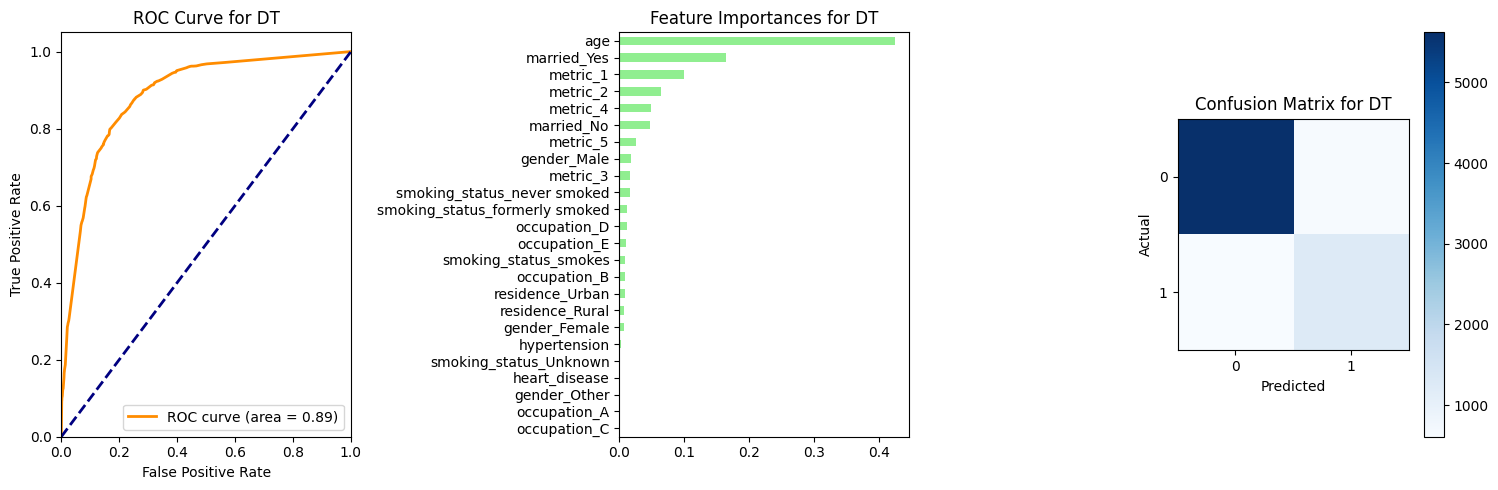

In [9]:
# Create subplots for visualization
plt.figure(figsize=(15, 5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.subplot(131)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for DT')
plt.legend(loc='lower right')

# Feature Importance Plot
importances = pd.Series(data=best_model1.feature_importances_, index=X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

plt.subplot(132)  # Use subplot(132) for the feature importance plot
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Feature Importances for DT')

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.subplot(133)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for DT")
plt.colorbar()
plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# 3. VOTING CLASSIFIER

In [10]:
# Set seed for reproducibility
SEED=1

# Instantiate lr
lr = LogisticRegression(random_state=SEED, max_iter=1000)

# Instantiate knn
knn = KNN(n_neighbors=27)

# Instantiate dt
dt = DecisionTreeClassifier(min_samples_leaf=0.13 , random_state=SEED)

# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

In [11]:
for clf_name, clf in classifiers:
    # Fit clf to the training set
    clf.fit(X_train, y_train)

    # Predict y_pred and calculate accuracy
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Predict probabilities and calculate AUC
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc_score = auc(fpr, tpr)

    # Print both accuracy and AUC side by side
    print(f'{clf_name} - Accuracy: {accuracy:.3f}, AUC: {auc_score:.3f}')

Logistic Regression - Accuracy: 0.870, AUC: 0.924
K Nearest Neighbours - Accuracy: 0.856, AUC: 0.919
Classification Tree - Accuracy: 0.808, AUC: 0.848


In [12]:
# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers, voting='soft')

# Fit vc to the training set
vc.fit(X_train, y_train)

# Predict probabilities and calculate AUC for the Voting Classifier
y_pred_prob = vc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = auc(fpr, tpr)

# Evaluate the test set predictions and calculate accuracy
y_pred = vc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Print both accuracy and AUC for the Voting Classifier side by side
print(f'Voting Classifier - Accuracy: {accuracy:.3f}, AUC: {auc_score:.3f}')

Voting Classifier - Accuracy: 0.876, AUC: 0.936


# 4. TUNED RANDOM FOREST

In [13]:
# Set a random seed for reproducibility
SEED = 3

# Instantiate RandomForestClassifier
rf = RandomForestClassifier(random_state=SEED)

# Define the hyperparameter search space specific to Random Forest
param_space_rf = {
    'n_estimators': (10, 200),            # Number of trees in the forest
    'max_depth': (2, 20),                # Maximum depth of each tree
    'min_samples_split': (2, 20),       # Minimum samples required to split an internal node
    'min_samples_leaf': (1, 20),        # Minimum samples required for each leaf node
    'max_features': (0.1, 1.0)         # Maximum number of features to consider for the best split
}

# Instantiate a Bayesian optimization search
bayes_search_rf = BayesSearchCV(
    rf,
    param_space_rf,
    n_iter=50,                         # Number of search iterations
    scoring='roc_auc',                  # Use ROC AUC as the scoring metric
    cv=5,
    random_state=SEED,
    n_jobs=-1
)

# Fit the Bayesian search on your data
bayes_search_rf.fit(X_train, y_train)

# Extract the best hyperparameters
best_hyperparams = bayes_search_rf.best_params_
print('Best hyperparameters:', best_hyperparams)

# Extract the best model
best_model2 = bayes_search_rf.best_estimator_

# Predict on the test set
y_pred = best_model2.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Calculate ROC AUC score
y_prob = best_model2.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

# Generate the full classification report
class_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# Print all information in a single statement
print(f"Test set accuracy: {test_accuracy:.3f}\nROC AUC score: {roc_auc:.3f}\nClassification Report:\n{class_report}")

Best hyperparameters: OrderedDict([('max_depth', 20), ('max_features', 0.1), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 131)])
Test set accuracy: 0.932
ROC AUC score: 0.976
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.97      0.96      6265
     Class 1       0.90      0.80      0.84      1879

    accuracy                           0.93      8144
   macro avg       0.92      0.88      0.90      8144
weighted avg       0.93      0.93      0.93      8144



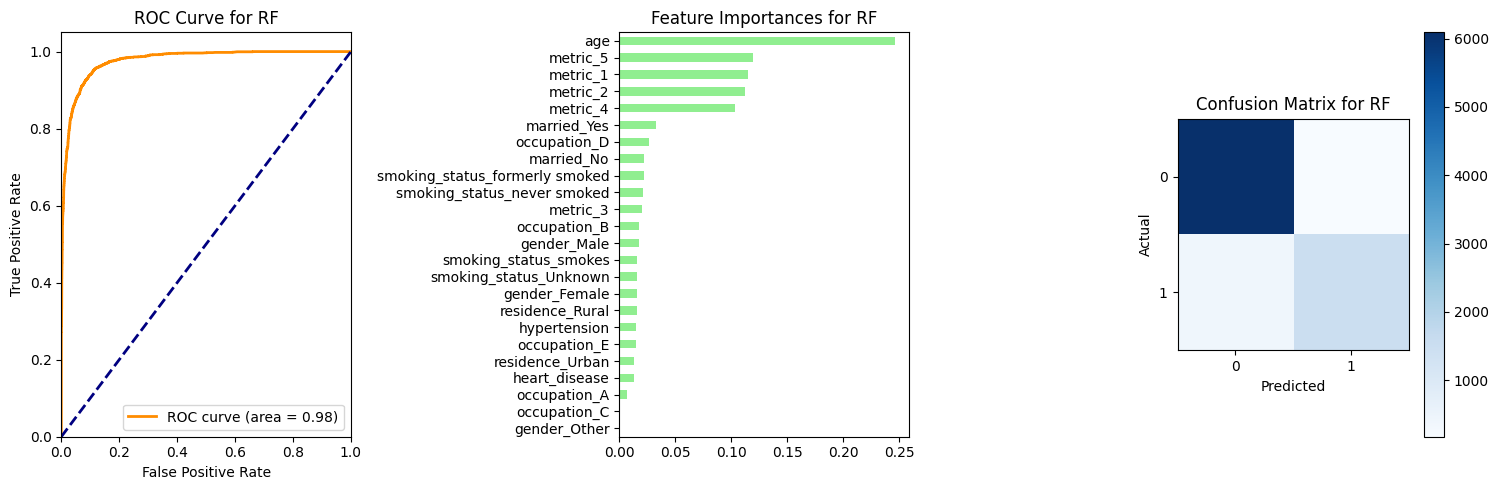

In [14]:
# Create subplots for visualization
plt.figure(figsize=(15, 5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.subplot(131)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RF')
plt.legend(loc='lower right')

# Feature Importance Plot
importances = pd.Series(data=best_model2.feature_importances_, index=X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

plt.subplot(132)  # Use subplot(132) for the feature importance plot
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Feature Importances for RF')

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.subplot(133)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for RF")
plt.colorbar()
plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# 5. TUNED STOCHASTIC GRADIENT BOOSTING

In [15]:
# Instantiate a Stochastic Gradient Boosting Classifier
SEED = 2
sgbc = GradientBoostingClassifier(random_state=SEED)

# Define the hyperparameter search space specific to Stochastic Gradient Boosting
param_space_sgbc = {
    'n_estimators': (10, 200),           # Number of boosting stages (trees)
    'max_depth': (2, 20),               # Maximum depth of each tree
    'subsample': (0.1, 1.0),           # Fraction of samples used for fitting the trees
    'max_features': (0.1, 1.0),       # Fraction of features used for fitting the trees
    'learning_rate': (0.01, 0.3)
}

# Instantiate a Bayesian optimization search
bayes_search_sgbc = BayesSearchCV(
    sgbc,
    param_space_sgbc,
    n_iter=50,                         # Number of search iterations
    scoring='roc_auc',                  # Use ROC AUC as the scoring metric
    cv=5,
    random_state=SEED,
    n_jobs=-1
)

# Fit the Bayesian search on your data
bayes_search_sgbc.fit(X_train, y_train)

# Extract the best hyperparameters
best_hyperparams = bayes_search_sgbc.best_params_
print('Best hyperparameters:', best_hyperparams)

# Extract the best model
best_model3 = bayes_search_sgbc.best_estimator_

# Predict on the test set
y_pred = best_model3.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Calculate ROC AUC score
y_prob = best_model3.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

# Generate the full classification report
class_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# Print all information in a single statement
print(f"Test set accuracy: {test_accuracy:.3f}\nROC AUC score: {roc_auc:.3f}\nClassification Report:\n{class_report}")

Best hyperparameters: OrderedDict([('learning_rate', 0.3), ('max_depth', 15), ('max_features', 1.0), ('n_estimators', 183), ('subsample', 0.9606339427743997)])
Test set accuracy: 0.954
ROC AUC score: 0.985
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.99      0.97      6265
     Class 1       0.96      0.84      0.89      1879

    accuracy                           0.95      8144
   macro avg       0.95      0.91      0.93      8144
weighted avg       0.95      0.95      0.95      8144



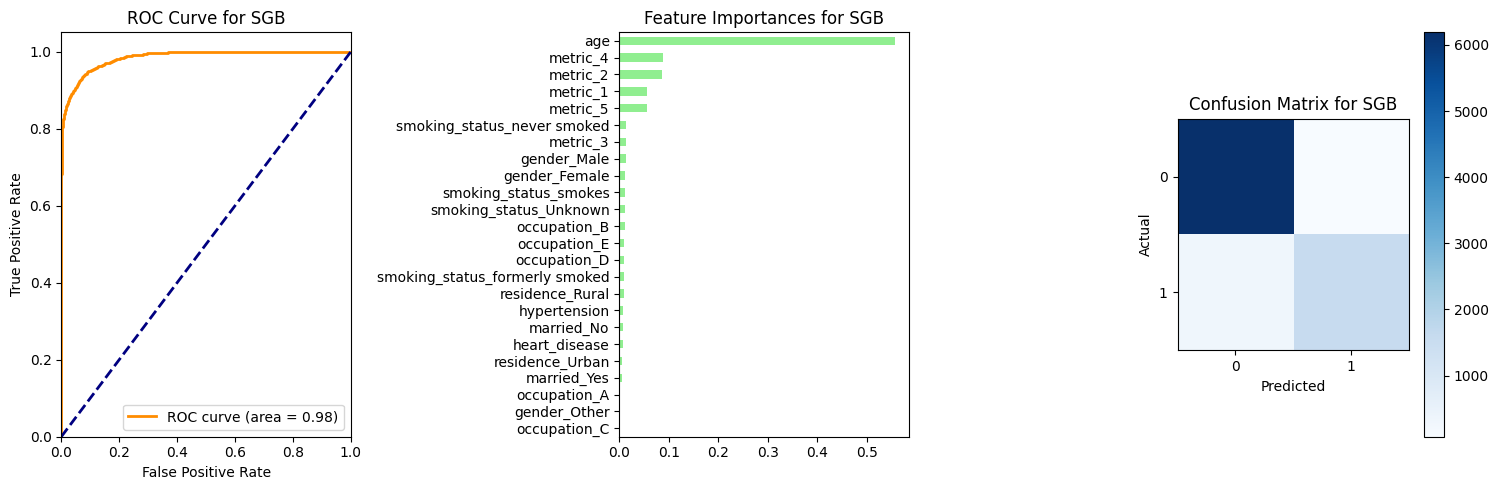

In [16]:
# Create subplots for visualization
plt.figure(figsize=(15, 5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.subplot(131)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SGB')
plt.legend(loc='lower right')

# Feature Importance Plot
importances = pd.Series(data=best_model3.feature_importances_, index=X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

plt.subplot(132)  # Use subplot(132) for the feature importance plot
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Feature Importances for SGB')

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.subplot(133)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SGB")
plt.colorbar()
plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# 6. Analysis

Ensemble algorithms like Random Forest and Gradient Boosting enhance prediction accuracy by combining models, reducing overfitting, and achieving balanced performance. They are useful for feature analysis and addressing non-linear patterns. Decision trees were used as the foundation for a few of these algorithms due to their robustness, relative efficiency and versatility. 

The Decision Tree model, while interpretable and reasonably accurate, lags behind the ensemble methods in terms of overall performance. Its limitations include overfitting and a higher rate of false negatives for Class 1. The Voting Classifier is hampered by the performance of its weakest component, the Classification Tree, making it less competitive compared to Random Forest and Stochastic Gradient Boosting. Random Forest stands out with high accuracy and ROC AUC, making it a great choice for stroke risk prediction but stochastic Gradient Boosting offers the best overall performance, with the highest accuracy and ROC AUC, making it the preferred choice within the context of the stroke dataset.

The variations in feature importance across different models can be attributed to how each model makes its predictions and the inherent characteristics of the algorithms. The Random Forest Classifier seems to capture more of the feature interactions than both the Decision Tree and the Boosting algorithm. This could be attributed to the randomness inherently present in a RF classifiers training process. Regardless, "Age" is a universally significant risk factor for stroke and thus is the most important feature to pay attention to. 

# 7. What it means in the Real World

Machine learning has become a critical avenue for implementing early intervention and prevention. By utilizing machine learning methods, such as the models created above, clinics and other healthcare organizations can establish a risk profiling system for patients during routine check-ups. More complex systems can efficiently evaluate an individual's stroke risk by inputting essential patient data, including age, blood pressure, cholesterol levels, and lifestyle factors. Consequently, high-risk patients can be proactively identified and offered interventions. The integration of machine learning promotes a proactive, data-driven approach to stroke risk assessment and intervention planning, with the potential to reduce stroke incidence within a health org's patient population.